# O-GlcNAc Prediction

* Find this notebook at `EpyNN/epynnlive/ptm_protein/train.ipynb`.
* Regular python code at `EpyNN/epynnlive/ptm_protein/train.py`.

Run the notebook online with [Google Colab](https://colab.research.google.com/github/Synthaze/EpyNN/blob/main/epynnlive/ptm_protein/train.ipynb).

**Level: Advanced**

In this notebook we will review:

* Handling sequential string data which represents peptide sequences.
* Training of Feed-Forward (FF) and recurrent networks (LSTM).
* LSTM-based schemes with ``sequences=True``, multiple dense layers and dropout.

**It is assumed that all *basics* notebooks were already reviewed:**

* [Basics with Perceptron (P)](../dummy_boolean/train.ipynb)
* [Basics with string sequence](../dummy_string/train.ipynb)
* [Basics with numerical time-series](../dummy_time/train.ipynb)
* [Basics with images](../dummy_image/train.ipynb)

**<font color='red'>This notebook does not enhance, extend or replace EpyNN's documentation.</font>**

**Relevant documentation pages for the current notebook:**

* [Fully Connected (Dense)](https://epynn.net/Dense.html)
* [Long Short-Term Memory (LSTM)](https://epynn.net/LSTM.html)
* [Dropout - Regularization](https://epynn.net/Dropout.html)

## Environment and data

Follow [this link](prepare_dataset.ipynb) for details about data preparation.

Briefly, one set of sample features contains 21 amino acid-long peptides.

Positive peptides are *Homo sapiens* peptides retrieved from [The O-GlcNAc Database](https://www.oglcnac.mcw.edu). These peptides were all experimentally demonstrated to undergo *O*-GlcNAcylation which is a protein Post-Translational Modification (PTM).

Negative peptides are *presumably not* modified peptides. These sequences are part of a running project so we will not say much about them except that they are not present in the *O*-GlcNAc Database.

Disclaimer: We are the authors of both EpyNN and the *O*-GlcNAc Database \[[1](https://www.nature.com/articles/s41597-021-00810-4), [2](https://academic.oup.com/database/article/doi/10.1093/database/baab039/6323965)\].

In [1]:
# EpyNN/epynnlive/ptm_protein/train.ipynb
# Install dependencies
!git clone https://github.com/synthaze/EpyNN
!pip3 install -r EpyNN/requirements.txt
import sys
sys.path.insert(1, '/content/EpyNN')

# Standard library imports
import random

# Related third party imports
import numpy as np

# Local application/library specific imports
import epynn.initialize
from epynn.commons.library import (
    configure_directory,
    read_model,
)
from epynn.commons.maths import relu, softmax
from epynn.network.models import EpyNN
from epynn.embedding.models import Embedding
from epynn.lstm.models import LSTM
from epynn.flatten.models import Flatten
from epynn.dropout.models import Dropout
from epynn.dense.models import Dense
from epynnlive.ptm_protein.prepare_dataset import (
    prepare_dataset,
    download_sequences,
)
from epynnlive.ptm_protein.settings import se_hPars


########################## CONFIGURE ##########################
random.seed(1)

np.set_printoptions(threshold=10)

np.seterr(all='warn')
np.seterr(under='ignore')

configure_directory()

############################ DATASET ##########################
download_sequences()

X_features, Y_label = prepare_dataset(N_SAMPLES=1280)

Let's inspect our data.

In [2]:
print(len(X_features))     # Number of sequences (samples)
print(len(X_features[0]))  # Length of sequence (features)
print(X_features[0])       # First sequence
print(Y_label[0])          # Associated label

1280
21
['T', 'A', 'A', 'M', 'R', 'N', 'T', 'K', 'R', 'G', 'S', 'W', 'Y', 'I', 'E', 'A', 'L', 'A', 'Q', 'V', 'F']
1


Note that this sequence has a one-label, meaning that it is presumably not modified.

However.

In [3]:
print(X_features[0][:10], X_features[0][10], X_features[0][11:])

['T', 'A', 'A', 'M', 'R', 'N', 'T', 'K', 'R', 'G'] S ['W', 'Y', 'I', 'E', 'A', 'L', 'A', 'Q', 'V', 'F']


Note the 11th amino acid is a serine (S), although this sequence is presumably not modified.

Time to recall that *O*-GlcNAcylation specifically impacts the subset of serine (S) and threonine (T) within the whole set of such amino acids in proteins.

All sequences in this exemple were centered: 10 amino acids on the left side; the S or T in the center; ten other amino acids on the right side.

Negative sequences all contain a S or a T at the 11th position, as the positive sequences do. This is to avoid biasing the problem: it is of interest to know which sequence containing S or T may be modified. But it is of no interest to train a network at finding out that sequences with no S or T will not be modified. That's trivial.

About N- and C- terminal moities of proteins which are prone to PTMs: on those we cannot follow the format \[10 amino acids\] \[S or T\] \[10 amino acids\] just because if S/T is at position 6, there is only 5 amino acids on the left side.

Below is a list of options in this case:

* **Exclude those peptides**: Well, this is the *technically* best option but in terms of biological relevance it is the worst: because protein extremities are most often unstructured and/or solvent-exposed, they are over-represented as undergoing modifications. So we must include them otherwise our dataset will not be representative of the problem.
* **Go with \[5 amino acids\] \[S or T\] \[10 amino acids\]**: While this can be done using recurrent architectures which accept input sequences of variable length, it cannot be done with pure Feed-Forward networks. Recurrent architectures process the sequence steps one by one and the weights are defined with respect to the number of recurrent cells and vocabulary size, not the length of the sequence. But Feed-Forward networks and precisely the *dense* layer has one dimension less compared to the *RNN* layer. Weight shape is defined with respect to the number of nodes and features. Therefore, if the latter changes, the maths can not operate as it is.
* **Pad the sequence such as \[0, 0, 0, 0, 0\] \[5 amino acids\] \[S or T\] \[10 amino acids\]**: This enables us to include such peptides in our dataset regardless if we intend to use Feed-Forward or recurrent architectures. Moreover, it preserves the centering around the 11th position and explicitely states that *"the number of padding characters is proportional to the closeness of the S/T from the protein first (left side) or last (right side) amino-acid"*

We have chosen the last option, padding, and used the character ``_`` instead of zero to avoid confusion between data types.

In [4]:
print('\n'.join([''.join(features) for features in X_features if '_' in features][0:10]))

GTEGKSRGSSSSSRCL_____
SASGAASTTTTASKAQ_____
CSIPSIKPPSTAN________
VGNFTGAKQASSQSWVPG___
PNQSFPHSVKTTTHSWVSG__
_______MIATPLKHSRIYLP
________MKTPNAQEAEGQQ
________MPSDLAKKKAAKK
______MDPNTIIEALRGTMD
___MAAAAELSLLEKSLGLSK


Therefore, the character ``_`` is part of our vocabulary size along with the 20 canonical amino acids.

## Feed-Forward (FF)

We will give it a quick try with a 2-layers Feed-Foward network regularized by a double dropout. We already had many discussions about this architecture in other notebook so we pass. 

Just note that the following network considers each data point as independent from the others around it. Said differently, it considers *a priori* that the probability of a given residue type at position ``i`` is unrelated to the residue type at position ``i - 1``. Which we know is not true. Amino acids have each their own distribution, but the arrangement of amino acids between each other in proteins is not random. There are more frequent combinations with respect to amino acid distributions.

### Embedding

We proceed with one-hot encoding of sample string features and label.

In [5]:
embedding = Embedding(X_data=X_features,
                      Y_data=Y_label,
                      X_encode=True,
                      Y_encode=True,
                      batch_size=32,
                      relative_size=(2, 1, 0))

We have set a batch size of 32, but this setting is empirical. You may want to change it and see.

### Flatten-(Dense)n with Dropout

Since we already discussed this architecture in other notebooks, we proceed readily.

In [6]:
name = 'Flatten_Dropout-02_Dense-64-relu_Dropout-03_Dense-2-softmax'

se_hPars['learning_rate'] = 0.001

flatten = Flatten()

dropout1 = Dropout(drop_prob=0.2)

hidden_dense = Dense(64, relu)

dropout2 = Dropout(drop_prob=0.3)

dense = Dense(2, softmax)

layers = [embedding, flatten, dropout1, hidden_dense, dropout2, dense]

model = EpyNN(layers=layers, name=name)

We can go ahead and initialize the model.

In [7]:
model.initialize(loss='MSE', seed=1, se_hPars=se_hPars.copy(), end='\r')

Start the training.

In [8]:
model.train(epochs=100, init_logs=False)

Epoch 99 - Batch 25/25 - Accuracy: 0.969 Cost: 0.05453 - TIME: 27.56s RATE: 3.63e+00e/s TTC: 1s     

+-------+----------+----------+----------+-------+--------+-------+------------------------------------------------------------------------+
| epoch |  lrate   |  lrate   | accuracy |       |  MSE   |       |                               Experiment                               |
|       |  Dense   |  Dense   |  dtrain  | dval  | dtrain | dval  |                                                                        |
+-------+----------+----------+----------+-------+--------+-------+------------------------------------------------------------------------+
|   0   | 1.00e-03 | 1.00e-03 |  0.529   | 0.583 | 0.253  | 0.242 | 1635012762_Flatten_Dropout-02_Dense-64-relu_Dropout-03_Dense-2-softmax |
|  10   | 1.00e-03 | 1.00e-03 |  0.674   | 0.621 | 0.216  | 0.225 | 1635012762_Flatten_Dropout-02_Dense-64-relu_Dropout-03_Dense-2-softmax |
|  20   | 1.00e-03 | 1.00e-03 |  0.760   | 0.670 | 0

We are pretty much overfitting the training data whereas we used a double dropout. 

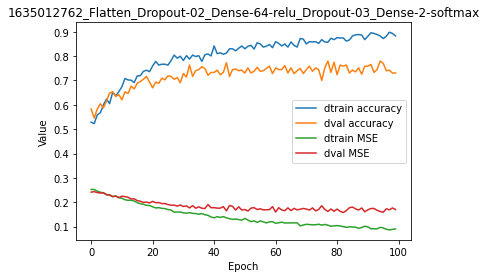

In [9]:
model.plot(path=False)

We could try to optimize by using a different loss function, adding one hidden *dense* layer or decreasing the number of nodes while increasing the learning rate etc... But we will not herein, because we want to work with recurrent architectures :).

For code, maths and pictures behind the *Flatten*, *Dense* and *Dropout* layers, follow these links:

* [Flatten - Adapter](https://epynn.net/Flatten.html)
* [Fully Connected (Dense)](https://epynn.net/Dense.html)
* [Dropout - Regularization](https://epynn.net/Dropout.html)

## Recurrent Architectures

Let see the big picture.

Sequence logo of *Homo sapiens* *O*-GlcNAcylated peptides consensus from [The O-GlcNAc Database Consensus](https://www.oglcnac.mcw.edu/consensus/) page.

![Sequence logo Homo-sapens O-GlcNAcylated peptides](dl_seqlogo_ST_Homo.png)

This is what is classically looked at when quickly evaluating if a sequence may or may not be modified: herein residues with positive values on the y-axis are over-represented within modified peptides while those with negative y-axis values are under-represented. This with respect to the position on the x-axis.

While this plot provides information on amino acid distribution with respect to a given position, it provides zero information about amino acid distribution with respect to position in the context of the sequence.

Just making a simple drawing:

In [10]:
seqA = 'AAA'
seqB = 'BBB'

The consensus for those two sequences is 50/50 A/B with respect to position in sequence.

In [11]:
seqA = 'BAB'
seqB = 'ABA'

The consensus for those two sequences is 50/50 A/B with respect to position in sequence.

Said differently: the consensus is the same, while the character patterns are totally unrelated.

Conclusion: when representing sequences with metrics that exclude the sequential nature of the data, we may get quite misleading representations overall.

That's where the recurrent architectures comes in: it postulates *a priori* that elements in one sequence are linked together. When processing sample features step by step - or position by position -, the output at a given position integrates results gained from the past positions. This is intrinsically - hard-written - in the code of the architecture.

### Embedding

Here we use the same embedding settings as for the Feed-Forward network.

In [12]:
embedding = Embedding(X_data=X_features,
                      Y_data=Y_label,
                      X_encode=True,
                      Y_encode=True,
                      batch_size=32,
                      relative_size=(2, 1, 0))

We may continue with using *RNN* or *GRU* or *LSTM* layers. We will go ahead with LSTM first.

### LSTM-Dense

Briefly, the advtange of using LSTM cells in one LSTM layer is that it *"retains"* the information for more sequence steps compared to the simple *RNN*. The drawback is that it takes significantly longer computational time compared to the simple *RNN*.

In [13]:
name = 'LSTM-8_Dense-2-softmax'

se_hPars['learning_rate'] = 0.1
se_hPars['softmax_temperature'] = 5

lstm = LSTM(8)

dense = Dense(2, softmax)

layers = [embedding, lstm, dense]

model = EpyNN(layers=layers, name=name)

Here we have set a *LSTM* layer with 8 units and all defaults.

The output of the LSTM layer will be fed in the *dense* output layer.

In [14]:
model.initialize(loss='MSE', seed=1, se_hPars=se_hPars.copy(), end='\r')

Train the model.

In [15]:
model.train(epochs=20, init_logs=False)

Epoch 19 - Batch 25/25 - Accuracy: 0.906 Cost: 0.06667 - TIME: 11.21s RATE: 1.78e+00e/s TTC: 1s     

+-------+----------+----------+----------+-------+--------+-------+-----------------------------------+
| epoch |  lrate   |  lrate   | accuracy |       |  MSE   |       |            Experiment             |
|       |   LSTM   |  Dense   |  dtrain  | dval  | dtrain | dval  |                                   |
+-------+----------+----------+----------+-------+--------+-------+-----------------------------------+
|   0   | 1.00e-01 | 1.00e-01 |  0.509   | 0.499 | 0.250  | 0.250 | 1635012790_LSTM-8_Dense-2-softmax |
|   2   | 1.00e-01 | 1.00e-01 |  0.509   | 0.499 | 0.270  | 0.274 | 1635012790_LSTM-8_Dense-2-softmax |
|   4   | 1.00e-01 | 1.00e-01 |  0.491   | 0.501 | 0.256  | 0.255 | 1635012790_LSTM-8_Dense-2-softmax |
|   6   | 1.00e-01 | 1.00e-01 |  0.621   | 0.602 | 0.229  | 0.233 | 1635012790_LSTM-8_Dense-2-softmax |
|   8   | 1.00e-01 | 1.00e-01 |  0.659   | 0.639 | 0.216  | 0.222 

Plot results.

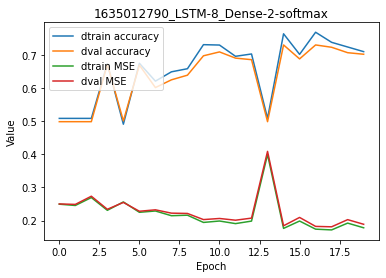

In [16]:
model.plot(path=False)

Results here are pretty good, with ~84% accuracy for both training and validation sets (epoch 14). Let's try to add more complexity in the model.

For code, maths and pictures behind the *LSTM* layer, follow this link:

* [Long Short-Term Memory (LSTM)](https://epynn.net/LSTM.html)

### LSTM(sequence=True)-Flatten-Dense

By default, the LSTM layer returns the hidden state computed at the last sequence step.

Consistently, gradients - what are actually used to update parameters - are computed with respect to this single last hidden step.

While this last hidden state incorporates information with respect to the whole sequence, it is commonly found that returning all hidden states and computing gradients with respect to each of them provides better results than the default behavior.

One drawback is that instead of returning an array of shape ``(m, 1, u)`` with ``m`` number of samples, ``1`` length of sequence and ``u`` the number of *LSTM* units within the layer, it returns an array of shape ``(m, s, u)``. Said differently, it return ``s`` times more data which makes computations slower.

It also requires the use of a *flatten* layer to get a shape such as ``(m, s * u)`` to adapt for the *dense* layer. When using the defaults ``LSTM(sequences=False)`` note that the returned data have shape ``(m, u)`` and not ``(m, 1, u)`` as stated above for pedagogic purpose.  This explains why we did not need a *flatten* layer in the first LSTM example.

In [17]:
name = 'LSTM-8-Seq_Flatten_Dense-2-softmax'

se_hPars['learning_rate'] = 0.1
se_hPars['softmax_temperature'] = 5

lstm = LSTM(8, sequences=True)

flatten = Flatten()

dense = Dense(2, softmax)

layers = [embedding, lstm, flatten, dense]

model = EpyNN(layers=layers, name=name)

Initialize the model.

In [18]:
model.initialize(loss='MSE', seed=1, se_hPars=se_hPars.copy(), end='\r')

Train for 20 epochs.

In [19]:
model.train(epochs=20, init_logs=False)

Epoch 19 - Batch 25/25 - Accuracy: 0.938 Cost: 0.03586 - TIME: 12.02s RATE: 1.66e+00e/s TTC: 1s     

+-------+----------+----------+----------+-------+--------+-------+-----------------------------------------------+
| epoch |  lrate   |  lrate   | accuracy |       |  MSE   |       |                  Experiment                   |
|       |   LSTM   |  Dense   |  dtrain  | dval  | dtrain | dval  |                                               |
+-------+----------+----------+----------+-------+--------+-------+-----------------------------------------------+
|   0   | 1.00e-01 | 1.00e-01 |  0.509   | 0.499 | 0.247  | 0.249 | 1635012801_LSTM-8-Seq_Flatten_Dense-2-softmax |
|   2   | 1.00e-01 | 1.00e-01 |  0.819   | 0.810 | 0.140  | 0.145 | 1635012801_LSTM-8-Seq_Flatten_Dense-2-softmax |
|   4   | 1.00e-01 | 1.00e-01 |  0.835   | 0.820 | 0.120  | 0.131 | 1635012801_LSTM-8-Seq_Flatten_Dense-2-softmax |
|   6   | 1.00e-01 | 1.00e-01 |  0.824   | 0.792 | 0.126  | 0.148 | 1635012801_LSTM-8-

Plot the results which look very good by a quick inspection on the table.

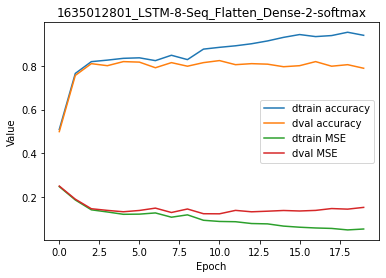

In [20]:
model.plot(path=False)

Overall, we increased accuracy on the training set but decreased accuracy on the validation set. Adding more complexity in the model did result in overfitting.

For code, maths and pictures behind the *LSTM* layer, follow this link:

* [Long Short-Term Memory (LSTM)](https://epynn.net/LSTM.html)

### LSTM(sequence=True)-Flatten-(Dense)n with Dropout

Adding one hidden *dense* layer will inevitably result in overfitting. So we set a double dropout each with a probability of 0.5 to pass values forward.

In [21]:
name = 'LSTM-8-Seq_Flatten_Dropout-05_Dense-64-relu_Dropout-05_Dense-2-softmax'

se_hPars['learning_rate'] = 0.1
se_hPars['softmax_temperature'] = 5

layers = [
    embedding,
    LSTM(8, sequences=True),
    Flatten(),
    Dropout(drop_prob=0.5),
    Dense(64, relu),
    Dropout(drop_prob=0.5),
    Dense(2, softmax),
]

model = EpyNN(layers=layers, name=name)

model.initialize(loss='MSE', seed=1, se_hPars=se_hPars.copy(), end='\r')

model.train(epochs=20, init_logs=False)

Epoch 19 - Batch 25/25 - Accuracy: 0.906 Cost: 0.07283 - TIME: 23.01s RATE: 8.69e-01e/s TTC: 2s     

+-------+----------+----------+----------+----------+-------+--------+-------+-----------------------------------------------------------------------------------+
| epoch |  lrate   |  lrate   |  lrate   | accuracy |       |  MSE   |       |                                    Experiment                                     |
|       |   LSTM   |  Dense   |  Dense   |  dtrain  | dval  | dtrain | dval  |                                                                                   |
+-------+----------+----------+----------+----------+-------+--------+-------+-----------------------------------------------------------------------------------+
|   0   | 1.00e-01 | 1.00e-01 | 1.00e-01 |  0.509   | 0.499 | 0.251  | 0.254 | 1635012814_LSTM-8-Seq_Flatten_Dropout-05_Dense-64-relu_Dropout-05_Dense-2-softmax |
|   2   | 1.00e-01 | 1.00e-01 | 1.00e-01 |  0.751   | 0.740 | 0.190  | 0.192 | 1635

Although we have a pretty harsh dropout setup, we still observe overfitting and the accuracy on the testing set turned out to be lower than without the hidden *dense* layer. This is to illustrate that even though the largest network is *theoretically* capable of the best regression, this comes with more difficulties in training. 

There is always the question of balancing between the metrics you get and how much they could be improved with respect to the human/computational time it may require.

For code, maths and pictures behind the *LSTM* layer, follow this link:

* [Long Short-Term Memory (LSTM)](https://epynn.net/LSTM.html)

## Write, read & Predict

A trained model can be written on disk such as:

In [22]:
model.write()

# model.write(path=/your/custom/path)

Make: /media/synthase/beta/EpyNN/epynnlive/ptm_protein/models/1635012814_LSTM-8-Seq_Flatten_Dropout-05_Dense-64-relu_Dropout-05_Dense-2-softmax.pickle


A model can be read from disk such as:

In [23]:
model = read_model()

# model = read_model(path=/your/custom/path)

We can retrieve new features and predict on them.

In [24]:
X_features, _ = prepare_dataset(N_SAMPLES=10)

dset = model.predict(X_features, X_encode=True)

Results can be extracted such as:

In [25]:
for n, pred, probs in zip(dset.ids, dset.P, dset.A):
    print(n, pred, probs)

0 1 [0.33365976 0.66634024]
1 0 [9.99969456e-01 3.05438656e-05]
2 1 [0.08005978 0.91994022]
3 1 [0.43855718 0.56144282]
4 1 [0.28151658 0.71848342]
5 1 [0.00511409 0.99488591]
6 0 [0.84836006 0.15163994]
7 0 [1.00000000e+00 3.07966686e-13]
8 0 [0.53816324 0.46183676]
9 1 [0.13825485 0.86174515]
